In [1]:
!pip install -q thop
!pip install -q torchsummary

In [1]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
# from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms

In [3]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [2]:
#檢查是否可用gpu
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [3]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.49121556 0.48211274 0.44650933] [0.24718854 0.24330655 0.26097178]
[0.49121556 0.48211274 0.44650933] [0.24718854 0.24330655 0.26097178]


In [4]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),

    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [5]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
image, label = trainset[0]
print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# 宣告 batch size
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
image shape:  torch.Size([3, 32, 32])
train length:  45000
val length:  5000
test length:  10000


# Task 1
1. 搭建由{CNN,BN,ReLU}所組成的layer
2. 用兩層layer搭配pooling layer 和 FC layer創建出model
3. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [6]:
import torch.nn.functional as F

#####   create your own model  #####
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = self.make_layer(3, 32)    # 3*32*32 -> 32*16*16
        self.layer2 = self.make_layer(32, 64)   # 32*16*16 -> 64*8*8
        self.layer3 = self.make_layer(64, 128)  # 64*8*8 -> 128*4*4
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(128*4*4, 10)

    def make_layer(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.fc(x.flatten(1))
        return x

# 宣告model
model = SimpleCNN().train().to(device)
model

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [7]:

from thop import profile
from torchsummary import summary
import numpy as np

##### 使用 thop 計算 FLOPs 和參數數量 #####
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
print(f"FLOPs: {flops}")
print(f"Params: {params}")

input_size = (3, 32, 32)
summary(model, input_size=(3, 32, 32), device="cuda")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 10571776.0
Params: 114186.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5         

In [8]:
def train(model, loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = outputs.argmax(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = train_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = outputs.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [17]:
def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return os.path.abspath(filename)

def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")

def load_model(model, filename: str, verbose: bool = True) -> None:
    state = torch.load(filename)
    model.load_state_dict(state)
    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")

def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    if filename:
        filename = preprocess_filename(filename)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)
        print(f"Plot saved at {filename}")
    plt.show()

In [14]:
##### setting parameter #####
EPOCH = 80
pre_epoch = 0
LR = 1e-3

In [15]:
##### Train model #####

# 初始化模型損失函數與優化器
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, mode="triangular2")

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10*LR, steps_per_epoch=len(trainloader), epochs=EPOCH)

# 設定參數
best_model_path = 'best_model.pth'  # 模型保存路徑

# 用於記錄 loss 和 accuracy 的列表
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 訓練模型
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0

    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, valloader, criterion)

    print(f'Epoch {epoch+1}/{EPOCH}', end=', ')
    print(f'Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}', end=', ')
    print(f'Train accuracy: {train_acc:.3f}, Validation accuracy: {val_acc:.3f}')

    # 記錄訓練損失和準確率
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_acc == max(val_accuracies):
        save_model(model.eval(), best_model_path, existed="overwrite")

print('Finished Training')

Epoch 1/80, Train loss: 0.828, Validation loss: 0.792, Train accuracy: 0.708, Validation accuracy: 0.721
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/best_model.pth (0.466274 MB)
Epoch 2/80, Train loss: 0.822, Validation loss: 0.791, Train accuracy: 0.713, Validation accuracy: 0.724
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/best_model.pth (0.466274 MB)
Epoch 3/80, Train loss: 0.823, Validation loss: 0.774, Train accuracy: 0.710, Validation accuracy: 0.729
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/best_model.pth (0.466274 MB)
Epoch 4/80, Train loss: 0.828, Validation loss: 0.780, Train accuracy: 0.711, Validation accuracy: 0.731
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/best_model.pth (0.466274 MB)
Epoch 5/80, Train loss: 0.817, Validation loss: 0.790, Train accuracy: 0.717, Validation accuracy: 0.732
Model saved at /home/master_112/nn6124030/eai2024/lab/lab2/best_model.pth (0.466274 MB)
Epoch 6/80, Train loss: 0.820, Vali

In [18]:
model = SimpleCNN().cuda().eval()
load_model(model, best_model_path)
test_loss, test_acc = evaluate(model, testloader, criterion)
print(f'Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}')

Model loaded from best_model.pth (0.466274 MB)


Test loss: 0.532, Test accuracy: 0.818


Plot saved at /home/master_112/nn6124030/eai2024/lab/lab2/loss_accuracy-7.png


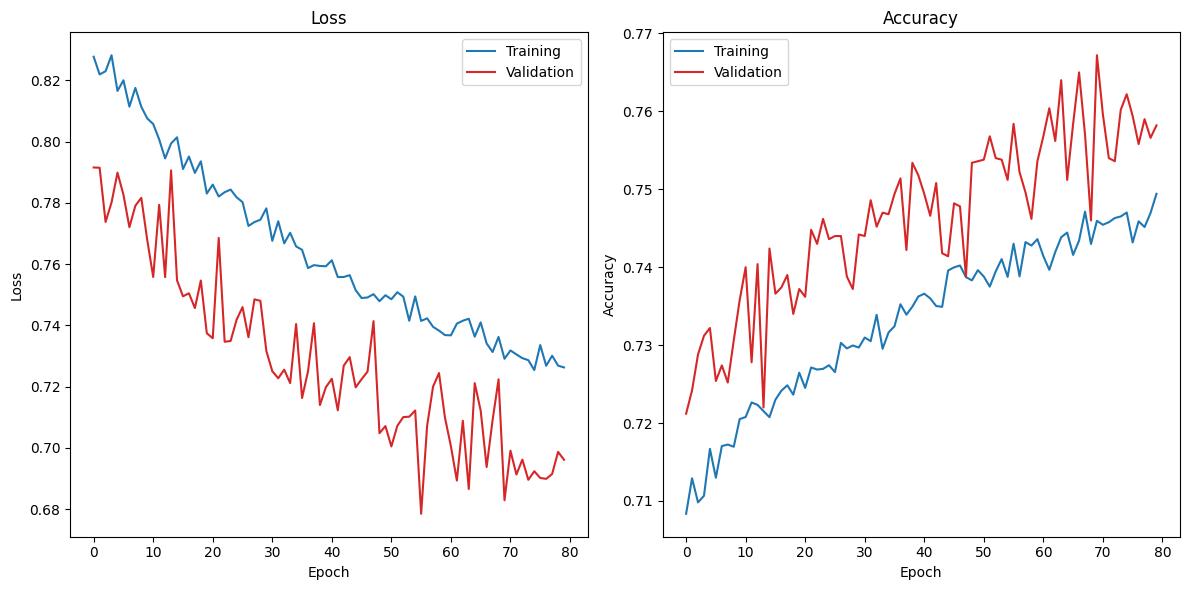

In [19]:
##### 繪製 loss 和 accuracy 的圖 #####
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, filename="./loss_accuracy.png")

# Task 2
1. 完成resnet18.py並上傳
2. 進行訓練並分別繪製出train acc/train loss/val acc/ val loss 等圖

In [23]:
from thop import profile
from resnet18 import *

model = ResNet18(ResBlock, [2, 2, 2, 2]).cuda()
input_size = (3, 32, 32)

flops, params = profile(model, inputs=(torch.randn(1, *input_size).cuda(),))
print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=input_size, device="cuda")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 557880320.0
Params: 11173962.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]   

In [15]:
# setting parameter
EPOCH = 100
pre_epoch = 0
LR = 1e-3

In [ ]:
#引用resnet.18
net = ResNet18(ResBlock,[2, 2, 2, 2]).to(device)

##### Train model #####


In [ ]:
##### 繪製 loss 和 accuracy 的圖 #####
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, filename="./task2/loss_accuracy.png")
plt.show()